In [226]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
import importlib
import qlbmlib
importlib.reload(qlbmlib)

<module 'qlbmlib' from '/home/tavaa/research/qlbm/qlbmlib.py'>

## Configuration

In [227]:
# Lattice configuration - 1D
GRID_SIZE = 32
NUM_ITERATIONS = 150

# D1Q3 lattice velocities (1D: left, stationary, right)
links = [[-1], [0], [1]]
weights = [1/6, 2/3, 1/6]
num_velocities = len(links)
speed_of_sound = 1/np.sqrt(3)

print(f"Grid size: {GRID_SIZE}")
print(f"Number of velocities: {num_velocities}")
print(f"Iterations: {NUM_ITERATIONS}")

Grid size: 32
Number of velocities: 3
Iterations: 150


## Initial Conditions

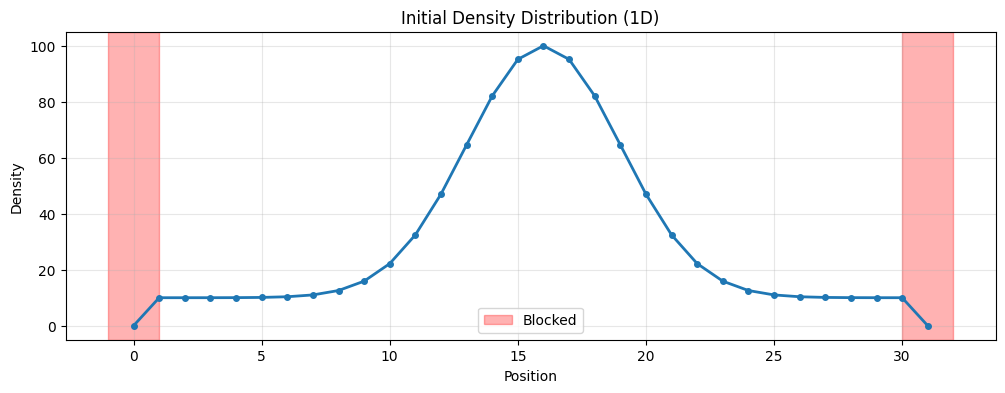

Initial density - Min: 0.00, Max: 100.00


In [251]:
def get_gaussian_distribution_1d(size: int, 
                                center: float = None,
                                sigma: float = 3.0,
                                amplitude: float = 100.0,
                                background: float = 10.0) -> NDArray[np.float64]:
    """Create a 1D Gaussian initial distribution.
    
    Args:
        size: Size of the 1D grid
        center: Center of the Gaussian (defaults to grid center)
        sigma: Standard deviation of the Gaussian
        amplitude: Peak amplitude
        background: Background density value
    """
    if center is None:
        center = size / 2
    
    x = np.arange(size)
    density = background + amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    
    # Set boundary sites (blocked) to zero
    density[0] = 0.0
    density[-1] = 0.0
    
    return density

# Create initial distribution
initial_density = get_gaussian_distribution_1d(GRID_SIZE, sigma=3.0, amplitude=90.0, background=10.0)

# Visualize
plt.figure(figsize=(12, 4))
plt.plot(initial_density, linewidth=2, marker='o', markersize=4)
plt.xlabel('Position')
plt.ylabel('Density')
plt.title('Initial Density Distribution (1D)')
plt.grid(True, alpha=0.3)
# Mark blocked sites (walls at 0 and 31, adjacent to fluid sites 1 and 30)
plt.axvspan(-1, 1, color='r', alpha=0.3, label='Blocked')
plt.axvspan(GRID_SIZE-2, GRID_SIZE, color='r', alpha=0.3)
plt.legend()
plt.show()

print(f"Initial density - Min: {initial_density.min():.2f}, Max: {initial_density.max():.2f}")

## Velocity Field

In [229]:
# Constant rightward velocity field
velocity_field = np.ones((1, GRID_SIZE)) * 0.1  # Velocity of 0.1 to the right

print(f"Velocity field shape: {velocity_field.shape}")
print(f"Velocity magnitude: {velocity_field[0, 0]:.2f}")

Velocity field shape: (1, 32)
Velocity magnitude: 0.10


## Boundary Condition Helpers

In [230]:
def create_identity_bc_1d(grid_size: int, num_velocities: int) -> NDArray[np.float64]:
    """Create identity boundary conditions (no transformation) for 1D."""
    bc = np.zeros((grid_size, num_velocities, num_velocities))
    for i in range(grid_size):
        bc[i] = np.eye(num_velocities)
    return bc

def create_bounceback_bc_1d(grid_size: int, 
                            links: list[list[int]]) -> NDArray[np.float64]:
    """Create bounce-back boundary conditions for 1D.
    
    Positions 0 and grid_size-1 are solid walls (always zero density).
    Bounce-back is applied at positions 1 and grid_size-2 (fluid sites next to walls):
    - At position 1 (next to left wall): left-moving particles bounce to right-moving
    - At position grid_size-2 (next to right wall): right-moving particles bounce to left-moving
    
    Args:
        grid_size: Size of the 1D grid
        links: List of velocity vectors (should be [[-1], [0], [1]] for D1Q3)
    """
    num_velocities = len(links)
    bc = create_identity_bc_1d(grid_size, num_velocities)
    
    # Find velocity indices
    left_idx = None
    stationary_idx = None
    right_idx = None
    
    for i, link in enumerate(links):
        if link[0] == -1:
            left_idx = i
        elif link[0] == 0:
            stationary_idx = i
        elif link[0] == 1:
            right_idx = i
    
    print(f"Velocity indices: left={left_idx}, stationary={stationary_idx}, right={right_idx}")
    
    # Position 1 (next to left wall): bounce back left-moving particles
    # Split 50/50 between opposite direction and stationary
    bc[1] = np.zeros((num_velocities, num_velocities))
    bc[1][left_idx, left_idx] = 0.0          # No particles moving left (they bounce)
    bc[1][stationary_idx, stationary_idx] = 1.0  # Stationary stays stationary
    bc[1][right_idx, right_idx] = 1.0        # Right-moving particles pass through
    bc[1][right_idx, left_idx] = 0.5         # 50% of left-moving becomes right-moving
    bc[1][stationary_idx, left_idx] = 0.5    # 50% of left-moving becomes stationary
    
    # Position grid_size-2 (next to right wall): bounce back right-moving particles
    # Split 50/50 between opposite direction and stationary
    bc[-2] = np.zeros((num_velocities, num_velocities))
    bc[-2][left_idx, left_idx] = 1.0         # Left-moving particles pass through
    bc[-2][stationary_idx, stationary_idx] = 1.0  # Stationary stays stationary
    bc[-2][right_idx, right_idx] = 0.0       # No particles moving right (they bounce)
    bc[-2][left_idx, right_idx] = 0.5        # 50% of right-moving becomes left-moving
    bc[-2][stationary_idx, right_idx] = 0.5  # 50% of right-moving becomes stationary
    
    return bc

print("Boundary condition helper functions defined (1D)")

Boundary condition helper functions defined (1D)


## Test 1: No Boundary Conditions (Identity)

In [231]:
# Create identity boundary conditions
bc_identity = create_identity_bc_1d(GRID_SIZE, num_velocities)

# Setup configuration
config_identity = [
    (NUM_ITERATIONS, velocity_field, links, weights, speed_of_sound, bc_identity)
]

# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dirname = f"experiments/BC_Identity_{timestamp}"
os.makedirs(dirname, exist_ok=True)

# Run simulation
output_file = f"{dirname}/simulation.csv"
qlbmlib.simulate_flow_classical(initial_density, config_identity, output_file)

print(f"Results saved to {dirname}")

Classical simulation: iterations 0-150/150
Classical Iteration 1/150
Classical Iteration 2/150
Classical Iteration 3/150
Classical Iteration 4/150
Classical Iteration 5/150
Classical Iteration 6/150
Classical Iteration 7/150
Classical Iteration 8/150
Classical Iteration 9/150
Classical Iteration 10/150
Classical Iteration 11/150
Classical Iteration 12/150
Classical Iteration 13/150
Classical Iteration 14/150
Classical Iteration 15/150
Classical Iteration 16/150
Classical Iteration 17/150
Classical Iteration 18/150
Classical Iteration 19/150
Classical Iteration 20/150
Classical Iteration 21/150
Classical Iteration 22/150
Classical Iteration 23/150
Classical Iteration 24/150
Classical Iteration 25/150
Classical Iteration 26/150
Classical Iteration 27/150
Classical Iteration 28/150
Classical Iteration 29/150
Classical Iteration 30/150
Classical Iteration 31/150
Classical Iteration 32/150
Classical Iteration 33/150
Classical Iteration 34/150
Classical Iteration 35/150
Classical Iteration 3

## Test 2: Bounce-Back Boundary Conditions

In [232]:
# Create bounce-back boundary conditions
bc_bounceback = create_bounceback_bc_1d(GRID_SIZE, links)

Velocity indices: left=0, stationary=1, right=2


In [233]:


# Setup configuration
config_bounceback = [
    (NUM_ITERATIONS, velocity_field, links, weights, speed_of_sound, bc_bounceback)
]

# Create output directory
dirname = f"experiments/BC_BounceBack_{timestamp}"
os.makedirs(dirname, exist_ok=True)

# Run simulation
output_file = f"{dirname}/simulation.csv"
qlbmlib.simulate_flow_classical(initial_density, config_bounceback, output_file)

print(f"Results saved to {dirname}")

Classical simulation: iterations 0-150/150
Classical Iteration 1/150
Classical Iteration 2/150
Classical Iteration 3/150
Classical Iteration 4/150
Classical Iteration 5/150
Classical Iteration 6/150
Classical Iteration 7/150
Classical Iteration 8/150
Classical Iteration 9/150
Classical Iteration 10/150
Classical Iteration 11/150
Classical Iteration 12/150
Classical Iteration 13/150
Classical Iteration 14/150
Classical Iteration 15/150
Classical Iteration 16/150
Classical Iteration 17/150
Classical Iteration 18/150
Classical Iteration 19/150
Classical Iteration 20/150
Classical Iteration 21/150
Classical Iteration 22/150
Classical Iteration 23/150
Classical Iteration 24/150
Classical Iteration 25/150
Classical Iteration 26/150
Classical Iteration 27/150
Classical Iteration 28/150
Classical Iteration 29/150
Classical Iteration 30/150
Classical Iteration 31/150
Classical Iteration 32/150
Classical Iteration 33/150
Classical Iteration 34/150
Classical Iteration 35/150
Classical Iteration 3

## Visualization Helper

In [252]:
def visualize_snapshots_1d(filename: str, grid_size: int, 
                          iterations: list[int] = None,
                          title: str = 'Simulation Snapshots') -> None:
    """Visualize 1D simulation snapshots at specified iterations.
    
    Args:
        filename: Path to CSV file containing simulation data
        grid_size: Size of the 1D grid
        iterations: List of iterations to display (defaults to 4 evenly spaced)
        title: Overall title for the figure
    """
    df = pd.read_csv(filename, header=None)
    
    if iterations is None:
        # Select 4 evenly spaced iterations
        n = len(df)
        iterations = [0, n//3, 2*n//3, n-1]
    
    # Get global min and max for consistent y-axis scale
    all_frames = [np.array(df.iloc[i]) for i in iterations]
    vmin = min(frame.min() for frame in all_frames)
    vmax = max(frame.max() for frame in all_frames)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=16)
    
    x = np.arange(grid_size)
    
    for idx, iter_num in enumerate(iterations):
        ax = axes[idx // 2, idx % 2]
        frame_data = np.array(df.iloc[iter_num])
        ax.plot(x, frame_data, linewidth=2, marker='o', markersize=4)
        ax.set_ylim(vmin * 0.9, vmax * 1.1)
        ax.set_xlabel('Position')
        ax.set_ylabel('Density')
        ax.set_title(f'Iteration {iter_num}')
        ax.grid(True, alpha=0.3)
        
        # Mark boundaries as filled spans (walls at 0 and 31, adjacent to fluid sites 1 and 30)
        ax.axvspan(-1, 1, color='r', alpha=0.3, label='Boundary' if idx == 0 else '')
        ax.axvspan(grid_size-2, grid_size, color='r', alpha=0.3)
        if idx == 0:
            ax.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_evolution_1d(filename: str, grid_size: int) -> None:
    """Create a space-time plot of the 1D evolution."""
    df = pd.read_csv(filename, header=None)
    
    # Stack all iterations into a 2D array
    data = np.array([df.iloc[i].to_numpy() for i in range(len(df))])
    
    plt.figure(figsize=(12, 8))
    plt.imshow(data, aspect='auto', cmap='viridis', origin='lower', 
               extent=[0, grid_size, 0, len(df)])
    plt.colorbar(label='Density')
    plt.xlabel('Position')
    plt.ylabel('Iteration')
    plt.title('Space-Time Evolution')
    
    # Mark boundaries as filled spans (walls at 0 and 31, adjacent to fluid sites 1 and 30)
    plt.axvspan(-0.5, 1.5, color='r', alpha=0.3, label='Boundary')
    plt.axvspan(grid_size-2.5, grid_size-0.5, color='r', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("Visualization helpers defined (1D)")

Visualization helpers defined (1D)


In [ ]:
def animate_simulation_1d(filename: str, grid_size: int, 
                         interval: int = 100,
                         title: str = 'Simulation Animation'):
    """Create an animated plot of the 1D simulation.
    
    Args:
        filename: Path to CSV file containing simulation data
        grid_size: Size of the 1D grid
        interval: Time between frames in milliseconds
        title: Title for the animation
    
    Returns:
        HTML animation object for display in notebook
    """
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    
    df = pd.read_csv(filename, header=None)
    
    # Get global min and max for consistent y-axis scale
    all_data = np.array([df.iloc[i].to_numpy() for i in range(len(df))])
    vmin = all_data.min()
    vmax = all_data.max()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(grid_size)
    
    # Initialize the line plot
    line, = ax.plot([], [], linewidth=2, marker='o', markersize=4)
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(vmin * 0.9, vmax * 1.1)
    ax.set_xlabel('Position')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    
    # Mark boundaries (walls at 0 and 31, adjacent to fluid sites 1 and 30)
    ax.axvspan(-1, 1, color='r', alpha=0.3, label='Boundary')
    ax.axvspan(grid_size-2, grid_size-0, color='r', alpha=0.3)
    ax.legend()
    
    # Title with iteration counter
    title_text = ax.set_title(f'{title} - Iteration 0')
    
    def init():
        line.set_data([], [])
        return line, title_text
    
    def animate(frame):
        y = df.iloc[frame].to_numpy()
        line.set_data(x, y)
        title_text.set_text(f'{title} - Iteration {frame}')
        return line, title_text
    
    anim = FuncAnimation(fig, animate, init_func=init, 
                        frames=len(df), interval=interval, 
                        blit=True, repeat=True)
    
    plt.close()  # Prevent duplicate display
    return HTML(anim.to_jshtml())

print("Animation helper defined (1D)")

Animation helper defined (1D)


## Animations

In [255]:
# Animate bounce-back BC results
animate_simulation_1d(
    f"experiments/BC_BounceBack_{timestamp}/simulation.csv",
    GRID_SIZE,
    interval=50,
    title='Bounce-Back BC'
)

## Compare Results

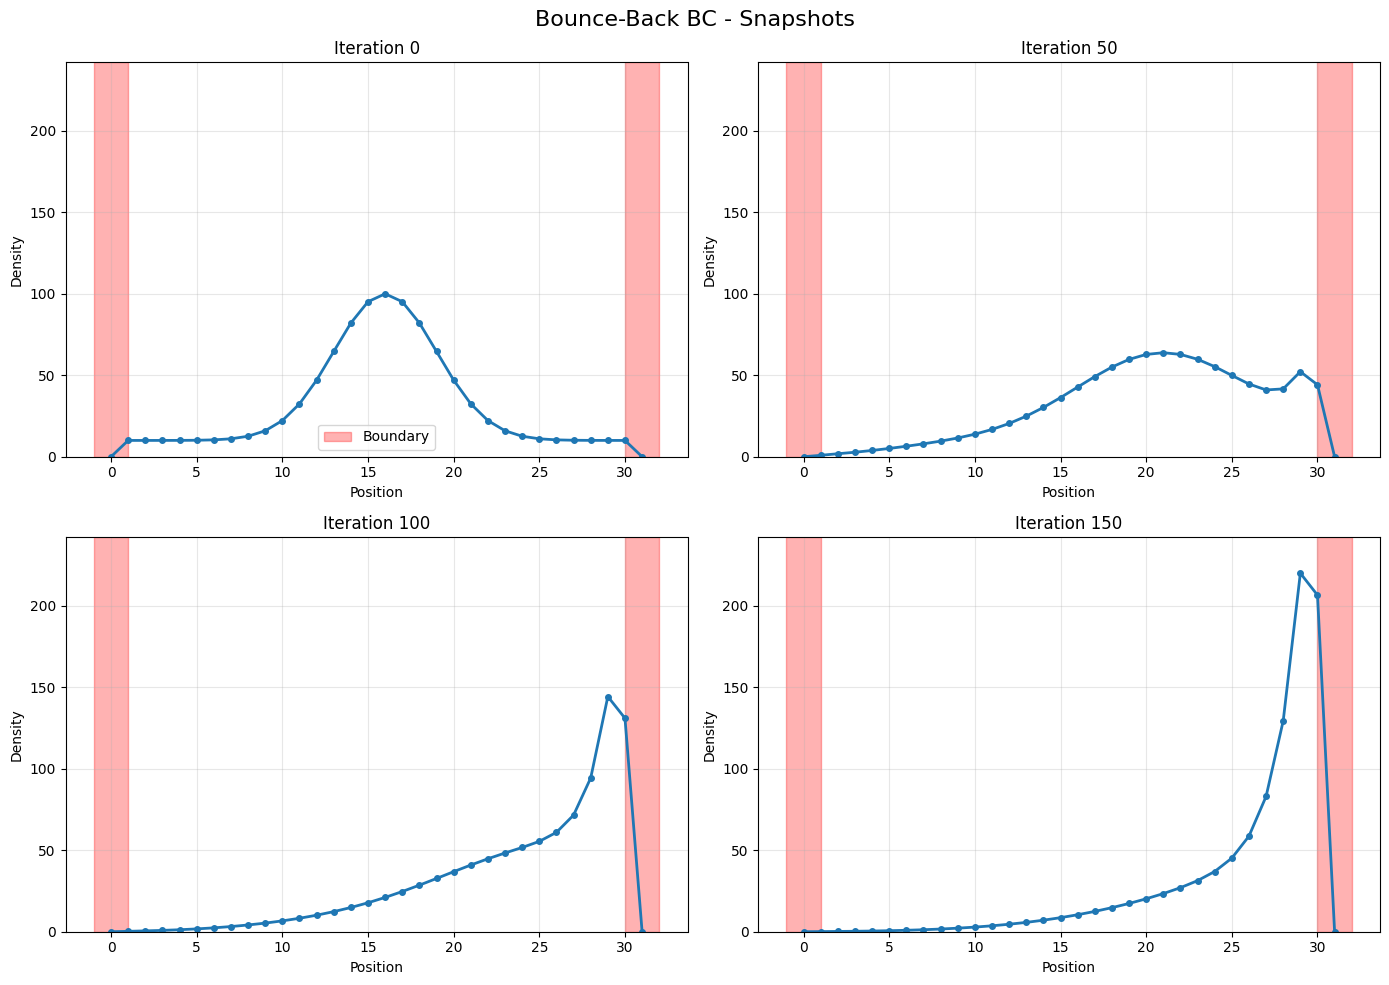

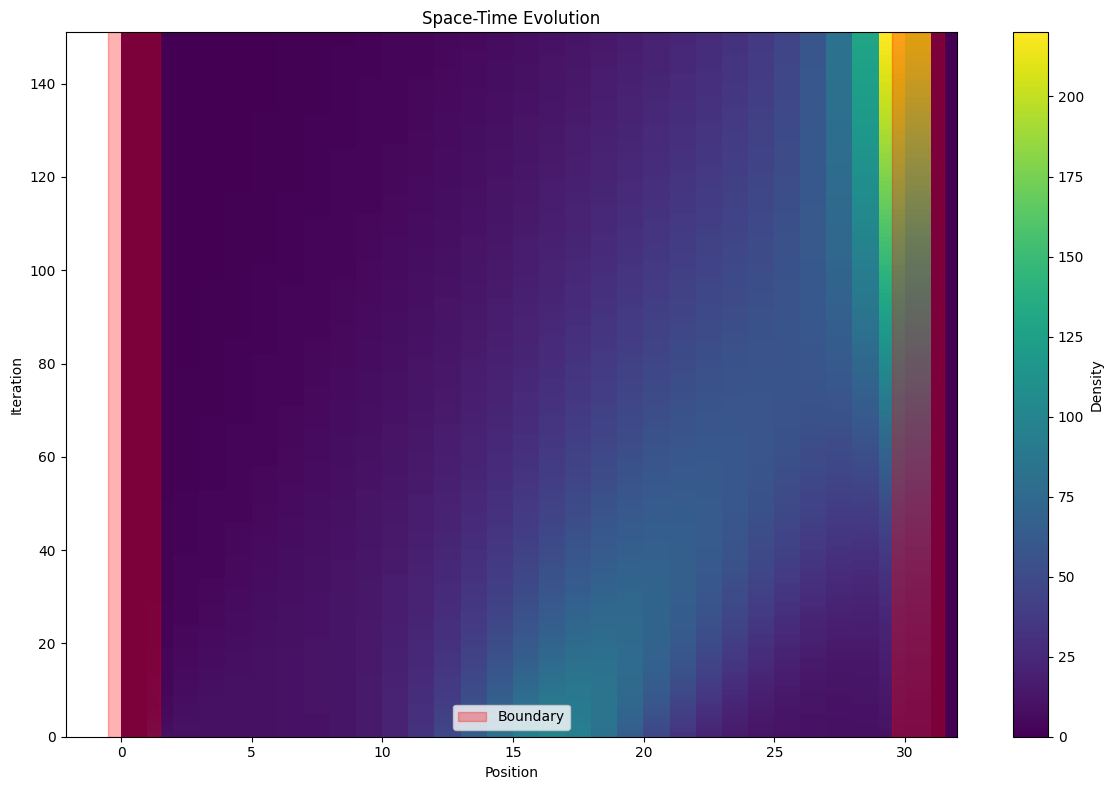

In [253]:
# Visualize bounce-back BC results - snapshots
visualize_snapshots_1d(
    f"experiments/BC_BounceBack_{timestamp}/simulation.csv",
    GRID_SIZE,
    title='Bounce-Back BC - Snapshots'
)

# Visualize bounce-back BC results - space-time
visualize_evolution_1d(
    f"experiments/BC_BounceBack_{timestamp}/simulation.csv",
    GRID_SIZE
)

## Analysis: Mass Conservation

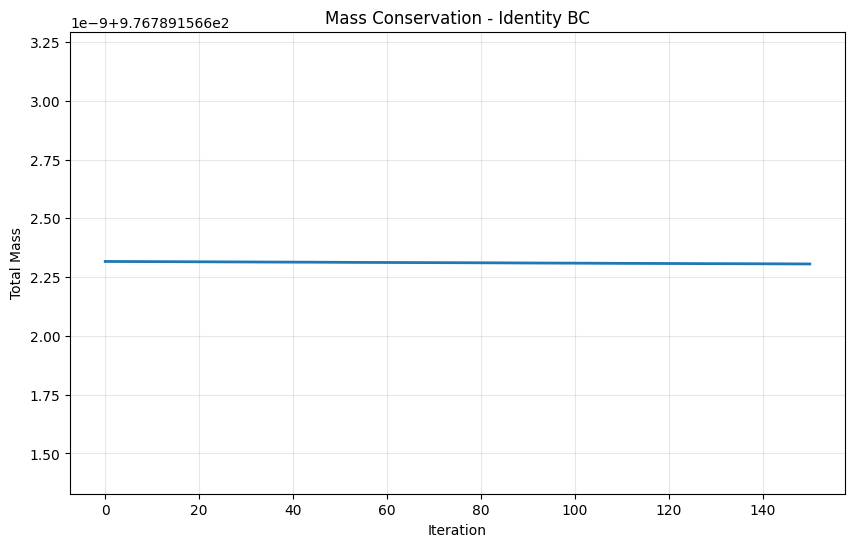

Identity BC:
  Initial mass: 976.789157
  Final mass: 976.789157
  Change: 0.000000%


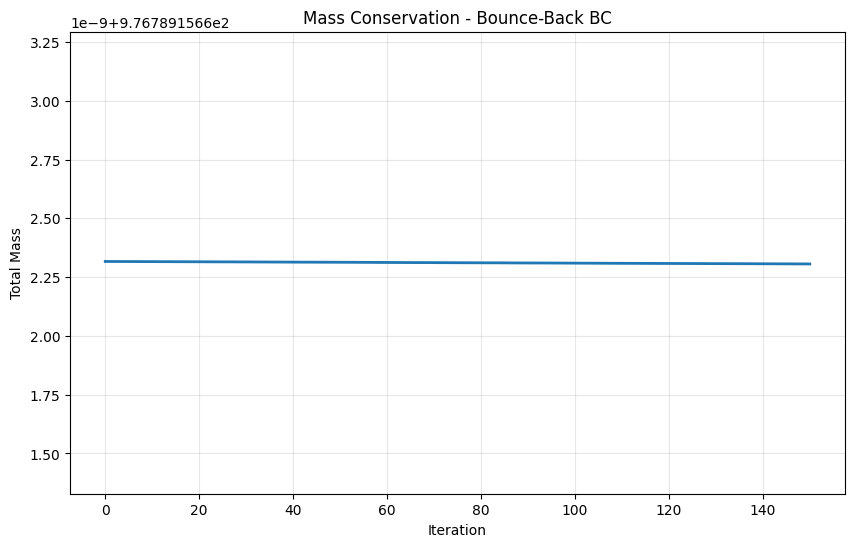

Bounce-Back BC:
  Initial mass: 976.789157
  Final mass: 976.789157
  Change: 0.000000%


In [240]:
def analyze_mass_conservation(filename: str, label: str) -> None:
    """Analyze mass conservation over time for 1D simulation."""
    df = pd.read_csv(filename, header=None)
    
    total_mass = []
    for i in range(len(df)):
        frame = df.iloc[i].to_numpy()
        total_mass.append(np.sum(frame))
    
    plt.figure(figsize=(10, 6))
    plt.plot(total_mass, linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Total Mass')
    plt.title(f'Mass Conservation - {label}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    initial_mass = total_mass[0]
    final_mass = total_mass[-1]
    mass_change = abs(final_mass - initial_mass) / initial_mass * 100
    
    print(f"{label}:")
    print(f"  Initial mass: {initial_mass:.6f}")
    print(f"  Final mass: {final_mass:.6f}")
    print(f"  Change: {mass_change:.6f}%")

# Analyze each boundary condition type
analyze_mass_conservation(
    f"experiments/BC_Identity_{timestamp}/simulation.csv",
    "Identity BC"
)

analyze_mass_conservation(
    f"experiments/BC_BounceBack_{timestamp}/simulation.csv",
    "Bounce-Back BC"
)